In [5]:
import tensorflow 
import numpy as np 
import pandas as pd 
from collections import Counter
import random
import IPython
from IPython.display import Image, Audio
import music21
from music21 import *
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adamax
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
import sys
import warnings
import os
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")
np.random.seed(42)

In [6]:
filepath = "C:/Users/HP/Downloads/Classic Music Midi/chopin/"
#Getting midi files
all_midis= []
for i in os.listdir(filepath):
    if i.endswith(".mid"):
        tr = filepath+i
        midi = converter.parse(tr)
        all_midis.append(midi)

In [7]:
#Helping function        
def extract_notes(file):
    notes = []
    pick = None
    for j in file:
        songs = instrument.partitionByInstrument(j)
        for part in songs.parts:
            pick = part.recurse()
            for element in pick:
                if isinstance(element, note.Note):
                    notes.append(str(element.pitch))
                elif isinstance(element, chord.Chord):
                    notes.append(".".join(str(n) for n in element.normalOrder))

    return notes
#Getting the list of notes as Corpus
Corpus= extract_notes(all_midis)
print("Total notes in all the Chopin midis in the dataset:", len(Corpus))

Total notes in all the Chopin midis in the dataset: 57894


In [8]:
def chords_n_notes(Snippet):
    Melody = []
    offset = 0 #Incremental
    for i in Snippet:
        #If it is chord
        if ("." in i or i.isdigit()):
            chord_notes = i.split(".") #Seperating the notes in chord
            notes = [] 
            for j in chord_notes:
                inst_note=int(j)
                note_snip = note.Note(inst_note)            
                notes.append(note_snip)
                chord_snip = chord.Chord(notes)
                chord_snip.offset = offset
                Melody.append(chord_snip)
        # pattern is a note
        else: 
            note_snip = note.Note(i)
            note_snip.offset = offset
            Melody.append(note_snip)
        # increase offset each iteration so that notes do not stack
        offset += 1
    Melody_midi = stream.Stream(Melody)   
    return Melody_midi

Melody_Snippet = chords_n_notes(Corpus[:100])


In [9]:
#Creating a count dictionary
count_num = Counter(Corpus)
print("Total unique notes in the Corpus:", len(count_num))

Total unique notes in the Corpus: 397


In [10]:
#Exploring the notes dictionary
Notes = list(count_num.keys())
Recurrence = list(count_num.values())
#Average recurrenc for a note in Corpus
def Average(lst):
    return sum(lst) / len(lst)
print("Average recurrenc for a note in Corpus:", Average(Recurrence))
print("Most frequent note in Corpus appeared:", max(Recurrence), "times")
print("Least frequent note in Corpus appeared:", min(Recurrence), "time")

Average recurrenc for a note in Corpus: 145.8287153652393
Most frequent note in Corpus appeared: 1627 times
Least frequent note in Corpus appeared: 1 time


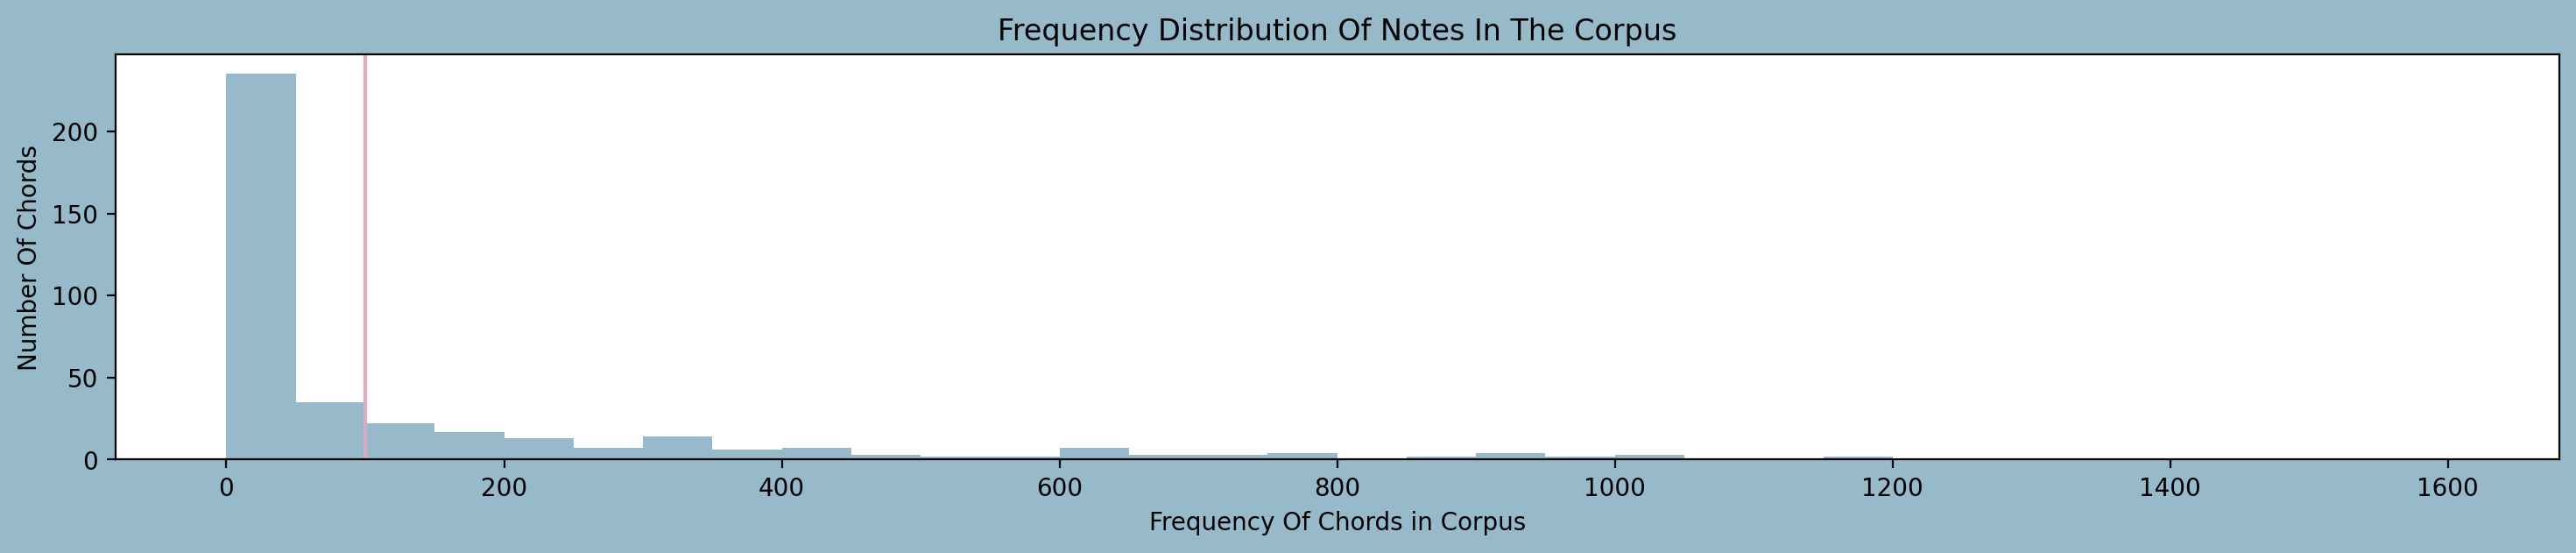

In [11]:
# Plotting the distribution of Notes
plt.figure(figsize=(18,3),facecolor="#97BACB")
bins = np.arange(0,(max(Recurrence)), 50) 
plt.hist(Recurrence, bins=bins, color="#97BACB")
plt.axvline(x=100,color="#DBACC1")
plt.title("Frequency Distribution Of Notes In The Corpus")
plt.xlabel("Frequency Of Chords in Corpus")
plt.ylabel("Number Of Chords")
plt.show()

In [12]:
#Getting a list of rare chords
rare_note = []
for index, (key, value) in enumerate(count_num.items()):
    if value < 100:
        m =  key
        rare_note.append(m)
        
print("Total number of notes that occur less than 100 times:", len(rare_note))

Total number of notes that occur less than 100 times: 270


In [13]:
#Eleminating the rare notes
for element in Corpus:
    if element in rare_note:
        Corpus.remove(element)

print("Length of Corpus after elemination the rare notes:", len(Corpus))

Length of Corpus after elemination the rare notes: 53753


In [14]:
# Storing all the unique characters present in my corpus to bult a mapping dic. 
symb = sorted(list(set(Corpus)))

L_corpus = len(Corpus) #length of corpus
L_symb = len(symb) #length of total unique characters

#Building dictionary to access the vocabulary from indices and vice versa
mapping = dict((c, i) for i, c in enumerate(symb))
reverse_mapping = dict((i, c) for i, c in enumerate(symb))

print("Total number of characters:", L_corpus)
print("Number of unique characters:", L_symb)

Total number of characters: 53753
Number of unique characters: 263


In [15]:
#Splitting the Corpus in equal length of strings and output target
length = 40
features = []
targets = []
for i in range(0, L_corpus - length, 1):
    feature = Corpus[i:i + length]
    target = Corpus[i + length]
    features.append([mapping[j] for j in feature])
    targets.append(mapping[target])
    
    
L_datapoints = len(targets)
print("Total number of sequences in the Corpus:", L_datapoints)

Total number of sequences in the Corpus: 53713


In [16]:
# reshape X and normalize
X = (np.reshape(features, (L_datapoints, length, 1)))/ float(L_symb)
# one hot encode the output variable
y = tensorflow.keras.utils.to_categorical(targets) 

In [17]:
#Taking out a subset of data to be used as seed
X_train, X_seed, y_train, y_seed = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
#Initialising the Model
model = Sequential()
#Adding layers
model.add(LSTM(512, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(256))
model.add(Dense(256))
model.add(Dropout(0.1))
model.add(Dense(y.shape[1], activation='softmax'))
#Compiling the model for training  
opt = Adamax(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=opt)

In [19]:
#Model's Summary               
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 40, 512)           1052672   
                                                                 
 dropout (Dropout)           (None, 40, 512)           0         
                                                                 
 lstm_1 (LSTM)               (None, 256)               787456    
                                                                 
 dense (Dense)               (None, 256)               65792     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 263)               67591     
                                                                 
Total params: 1,973,511
Trainable params: 1,973,511
Non-

In [20]:
history = model.fit(X_train, y_train, batch_size=256, epochs=200)

Epoch 1/200
168/168 [==============================] - 15s 24ms/step - loss: 4.7597
Epoch 2/200
168/168 [==============================] - 3s 20ms/step - loss: 4.6888
Epoch 3/200
168/168 [==============================] - 3s 19ms/step - loss: 4.6581
Epoch 4/200
168/168 [==============================] - 3s 20ms/step - loss: 4.5900
Epoch 5/200
168/168 [==============================] - 3s 19ms/step - loss: 4.5757
Epoch 6/200
168/168 [==============================] - 3s 19ms/step - loss: 4.5713
Epoch 7/200
168/168 [==============================] - 3s 19ms/step - loss: 4.5687
Epoch 8/200
168/168 [==============================] - 3s 19ms/step - loss: 4.5618
Epoch 9/200
168/168 [==============================] - 3s 20ms/step - loss: 4.5560
Epoch 10/200
168/168 [==============================] - 3s 19ms/step - loss: 4.5487
Epoch 11/200
168/168 [==============================] - 3s 18ms/step - loss: 4.5291
Epoch 12/200
168/168 [==============================] - 3s 18ms/step - loss: 4.4863


[Text(0.5, 0, 'Epochs')]

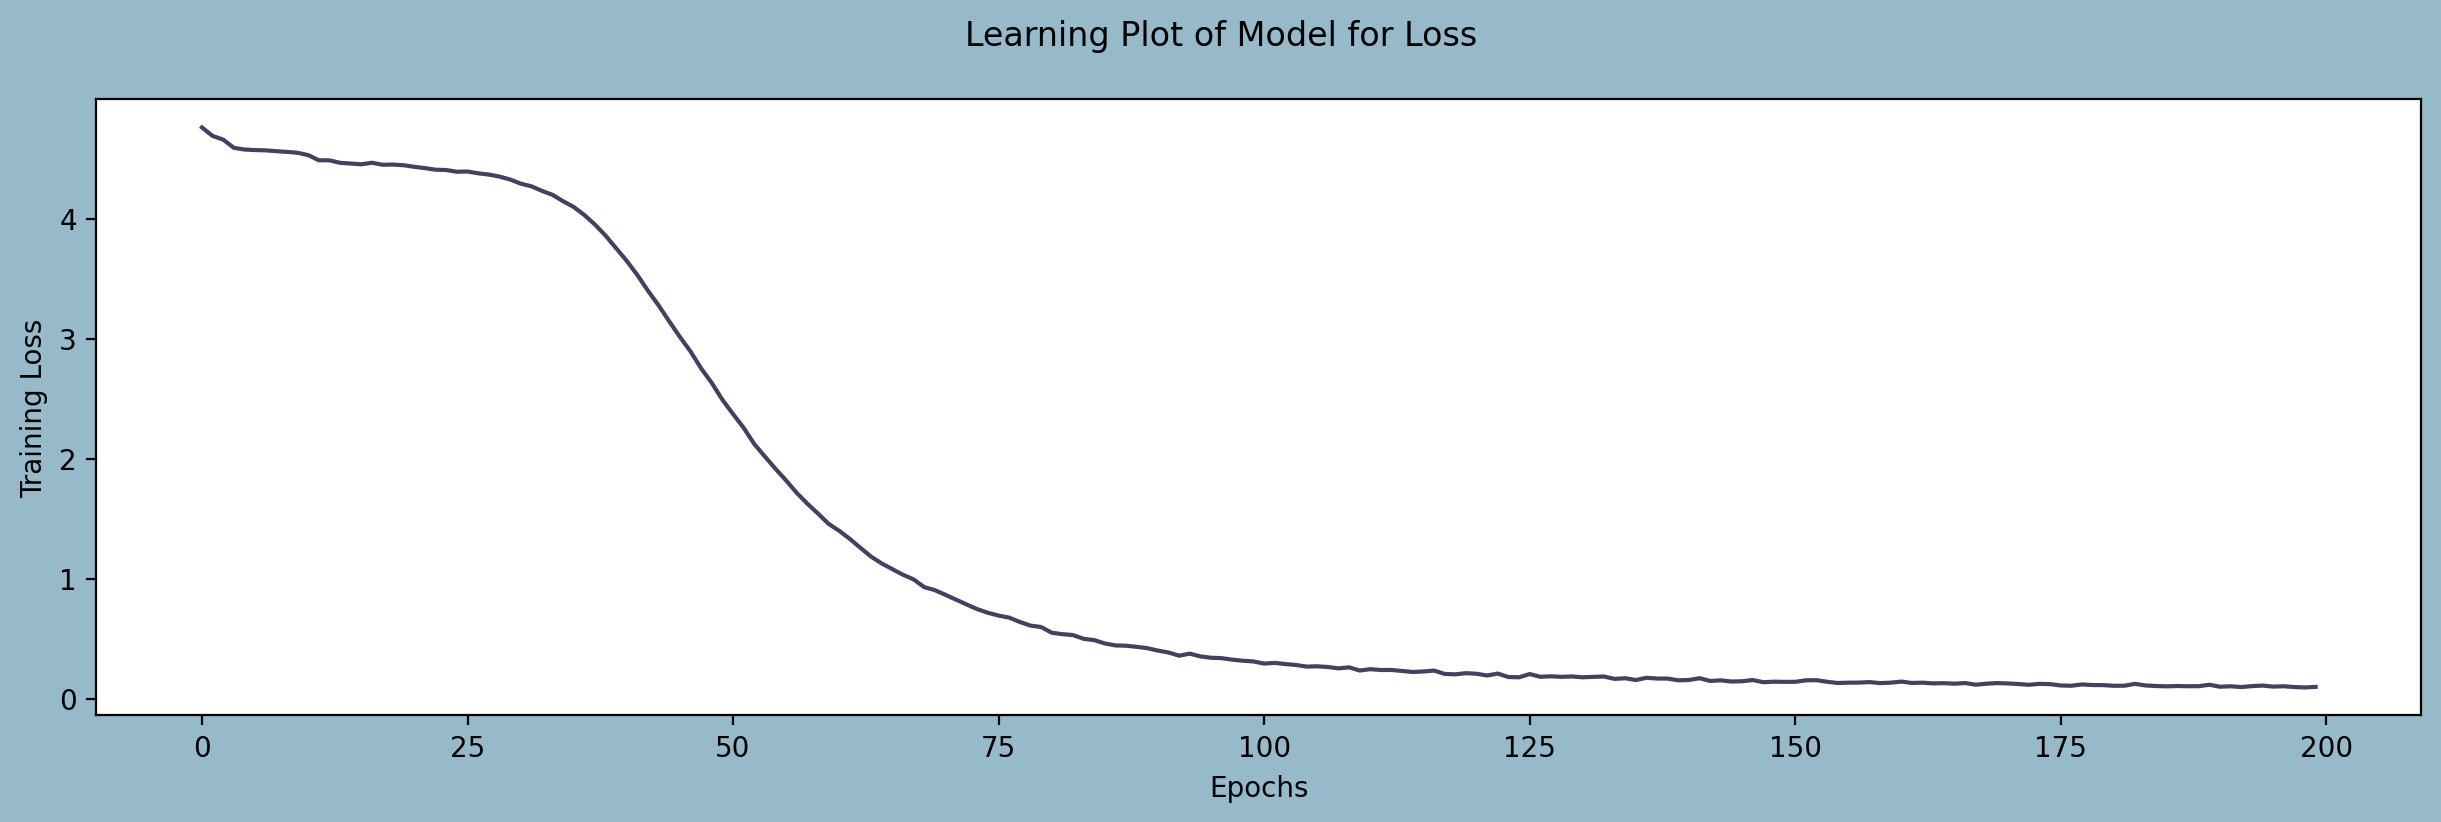

In [21]:
#Plotting the learnings 
history_df = pd.DataFrame(history.history)
fig = plt.figure(figsize=(15,4), facecolor="#97BACB")
fig.suptitle("Learning Plot of Model for Loss")
pl=sns.lineplot(data=history_df["loss"],color="#444160")
pl.set(ylabel ="Training Loss")
pl.set(xlabel ="Epochs")

In [22]:
def Malody_Generator(Note_Count):
    seed = X_seed[np.random.randint(0,len(X_seed)-1)]
    Music = ""
    Notes_Generated=[]
    for i in range(Note_Count):
        seed = seed.reshape(1,length,1)
        prediction = model.predict(seed, verbose=0)[0]
        prediction = np.log(prediction) / 1.0 #diversity
        exp_preds = np.exp(prediction)
        prediction = exp_preds / np.sum(exp_preds)
        index = np.argmax(prediction)
        index_N = index/ float(L_symb)   
        Notes_Generated.append(index)
        Music = [reverse_mapping[char] for char in Notes_Generated]
        seed = np.insert(seed[0],len(seed[0]),index_N)
        seed = seed[1:]
    #Now, we have music in form or a list of chords and notes and we want to be a midi file.
    Melody = chords_n_notes(Music)
    Melody_midi = stream.Stream(Melody)   
    return Music,Melody_midi


#getting the Notes and Melody created by the model
Music_notes, Melody = Malody_Generator(100)


In [23]:
#To save the generated melody
Melody.write('midi','Melody_Generated.mid')
#to play audio or corpus
IPython.display.Audio("../input/music-generated-lstm/Melody_Generated 2.wav")

ValueError: rate must be specified when data is a numpy array or list of audio samples.

In [ ]:
#to play audio or corpus
IPython.display.Audio("../input/music-generated-lstm/Melody_Generated_1.wav")

In [24]:
import joblib

In [26]:
joblib.dump(model,"model.h5")


INFO:tensorflow:Assets written to: ram://86792e66-4686-456d-a930-98cd472ee240/assets


INFO:tensorflow:Assets written to: ram://86792e66-4686-456d-a930-98cd472ee240/assets


['model.h5']

In [38]:
model.save('my_model.h5')

In [31]:
import tensorflow as tf
tf.saved_model.LoadOptions = '/job:localhost'

In [32]:
model2 = joblib.load(r"E:\ramakrishna\model.h5")

FileNotFoundError: Unsuccessful TensorSliceReader constructor: Failed to find any matching files for ram://5ad81819-f0c9-4780-bd2a-ac53f9717400/variables/variables
 You may be trying to load on a different device from the computational device. Consider setting the `experimental_io_device` option in `tf.saved_model.LoadOptions` to the io_device such as '/job:localhost'.

In [35]:
joblib.dump(model,"model2.h5")


INFO:tensorflow:Assets written to: ram://1fa0a61f-089d-48b4-a6c2-074bcd5a297b/assets


INFO:tensorflow:Assets written to: ram://1fa0a61f-089d-48b4-a6c2-074bcd5a297b/assets


['model2.h5']

In [36]:
model2 = joblib.load(r"E:\ramakrishna\model2.h5")

FileNotFoundError: Unsuccessful TensorSliceReader constructor: Failed to find any matching files for ram://0411126a-586d-4f23-a169-29fbb50b13c2/variables/variables
 You may be trying to load on a different device from the computational device. Consider setting the `experimental_io_device` option in `tf.saved_model.LoadOptions` to the io_device such as '/job:localhost'.

In [41]:
model2 = tf.keras.models.load_model('my_model.h5')


In [42]:
def Malody_Generator(Note_Count,model):
    seed = X_seed[np.random.randint(0,len(X_seed)-1)]
    Music = ""
    Notes_Generated=[]
    for i in range(Note_Count):
        seed = seed.reshape(1,length,1)
        prediction = model.predict(seed, verbose=0)[0]
        prediction = np.log(prediction) / 1.0 #diversity
        exp_preds = np.exp(prediction)
        prediction = exp_preds / np.sum(exp_preds)
        index = np.argmax(prediction)
        index_N = index/ float(L_symb)   
        Notes_Generated.append(index)
        Music = [reverse_mapping[char] for char in Notes_Generated]
        seed = np.insert(seed[0],len(seed[0]),index_N)
        seed = seed[1:]
    #Now, we have music in form or a list of chords and notes and we want to be a midi file.
    Melody = chords_n_notes(Music)
    Melody_midi = stream.Stream(Melody)   
    return Music,Melody_midi


#getting the Notes and Melody created by the model



In [43]:
Music_notes, Melody = Malody_Generator(100,model2)

In [44]:
print(Music_notes)

['4.9', 'C#4', '5.10', 'D4', '6.11', 'E-4', '7.0', 'E4', '8.1', 'F4', '9.2', 'F#4', '10.3', 'G4', '10.3', 'G4', '11.4', 'G#4', '10.3', '4', '4', '4', '8.11', '4', '8.11', '3', '7.10', '4', '8.11', '5', '9.0', '6', '10.1', '7', '11.2', '7', '11.2', '7', '11.2', '7', '11.2', '7', '11.2', '6', '10.1', '6', '10.1', '6', '10.1', '5', '9.0', '6', '9.0', '6.9', '9.10', '9.0', '9.1', '9.0', '0.3', '10.1.5', 'F#5', '11.2', '4.9', '4.9', '4.9', '9.0', '11.4', '4.9', '9.0', '4.9', '4.9', '0.5', '7.10', '7.0', '4.9', '5.9', '4.9', '6.11', '11.4', 'E2', 'G2', 'E3', '11.3', 'B3', 'B3', '0', '5.7', 'G3', '2', 'G4', 'G3', '4.9', '10.1', 'C#6', '2', '5.10', '10.1', '0.3', '10.1', '4']


In [45]:
print(Melody)

<music21.stream.Stream 0x24dd9836ce0>


In [46]:
Melody.write('midi','Melody_Generated.mid')

'Melody_Generated.mid'

In [47]:
Music_notes, Melody = Malody_Generator(100,model2)

In [48]:
print(Music_notes)

['10.0', 'G2', 'G2', 'C#2', 'A5', 'C#4', 'C4', '5', 'G#2', 'G#2', 'E-3', 'B3', 'G#3', 'C4', 'C3', 'F5', 'E-5', 'G#5', '9', 'C3', 'G3', 'G5', 'E4', 'F5', 'G#5', 'E3', 'E-5', 'E-5', 'E-5', 'F5', 'G#3', '1.5', 'C#3', 'C5', 'C5', 'C#3', 'F#4', 'C#3', 'F#4', 'B4', 'G#2', '1.4', 'F#5', 'F#5', 'E3', 'G#5', 'G#5', 'F#3', 'G#4', 'B4', '1.4', 'G#2', 'F#4', '3.6', 'C4', 'E5', 'G#3', 'E-5', 'E-5', 'A5', 'G#3', 'C#5', '1.4', 'G#3', 'E5', '1.5', 'G#3', 'G#3', '1.4', 'G#3', 'E-5', 'B-2', 'F#5', 'A3', '3.5.9', 'G#3', 'G#2', '10.1.5', 'G#3', 'F#5', '0.3', 'G#3', 'F#5', '1.5', 'G#3', 'G#3', '0.3', 'G#3', 'E-5', '3.8', 'G#3', 'G#3', '1.7', 'G#3', 'G#3', 'C#5', 'G#3', 'G#3', 'G#3', 'G#3']


In [49]:
Melody.write('midi','Melody_Generated.mid')

'Melody_Generated.mid'